# Turnover Constrained Mean-Variance Portfolio Optimization Study

The following study applies quadratic optimization techniques to control not only for a trader's level of risk aversion, but also turnover aversion (a proxy for trading costs). 

The purpose of this study is to test the efficacy of a range turnover penalization terms in the context of mean-variance optimization. 

Several simulations are run on a multi-asset tradable universe to capture the regularization effect of a turnover aware penalty term "delta" in the optimization's loss/objective function. The trader's risk-aversion parameter "gamma" is held constant to offer consistent comparison across "deltas". Each simulation is run for different "delta" value without actually penalizing the realized pnl. That is, we use different cost
penalties in the objective function but leave the realized costs unchanged. This is for pedagogical purposes and creates observable effects across varying turnover regularization magnitudes.

It is found that turnover-aware portfolios empirically provide cost-mitigation benefits and asymptotically tend toward the naive 1/N portfolio. The strategy deployed in this study is functionally equivilant to machine learning-based regularization methods.     

In [1]:
# %run C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\quant_tools\beta\cov_functions.py
# %run C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\quant_tools\beta\QuantPortfolioOpt_beta.py

from quant_tools.beta import QuantPortfolioOpt_beta as opt, cov_functions as risk_models
from quant_tools import performance_analysis as pa
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

In [2]:
# Returns of close returns
close_asset_returns = pd.DataFrame()

# Close Prices
close_asset_prices = pd.DataFrame()

tickers = ['SPY', 'BIL', 'TLT', 'ORLY', 'HYG', 'VNQ', 'FTAI', 'GLD', 'ES=F', 'YM=F', 'NQ=F', 'RTY=F', 'ZB=F', 'ZN=F', 'GC=F', 'SI=F', 'CL=F', 'NG=F', 'ZC=F', 'ZM=F', 'CT=F', 'OJ=F'] # # 

for ticker in tickers:

    prices = yf.download(ticker, start='2000-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_prices = prices['Adj Close'].dropna().rename(ticker)
    close_rets = close_prices.pct_change().dropna().rename(ticker)
    
    close_asset_prices = pd.concat([close_asset_prices, close_prices], axis=1)
    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)  

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
def plot_returns_from_opt(returns: pd.DataFrame, w: pd.DataFrame, year: int = 2008):
    n = returns.columns.size
    opt_returns = (w * returns.shift(-1)).sum(1).loc[dt.date(year, 1, 1):].rename(index='Opt')
    print(opt_returns.std()*np.sqrt(252))
    naive_returns = (np.array([1/n]*n) * returns).sum(1).loc[dt.date(year, 1, 1):].rename(index='1/N')
    pa.cumulative_returns(opt_returns).plot()
    pa.cumulative_returns(naive_returns).plot(label='1/N')
    plt.title('Realized Cumulative Returns')
    plt.legend()
    plt.show()

    scaled_mvo_returns= pa.scale_vol(opt_returns)
    scaled_naive_returns = pa.scale_vol(naive_returns)
    pa.cumulative_returns(scaled_mvo_returns).plot()
    pa.cumulative_returns(scaled_naive_returns).plot(label='1/N')
    plt.title('10% Vol Scaled Cumulative Returns')
    plt.legend()
    plt.show()
    (opt_returns.rolling(20).std()*252**.5).plot()
    (naive_returns.rolling(20).std()*252**.5).plot()
    return pa.performance_summary(pd.concat([opt_returns, naive_returns], axis=1))

def get_turnover(w: pd.DataFrame) -> tuple:
    
    # Absolute difference in shifted positions
    delta = np.abs(w - w.shift(1))

    # Total turnover for the portfolio
    total_turnover = np.sum(np.sum(delta))

    # Mean temporal turnover (per rebal period)
    mean_temporal_turnover = np.mean(np.mean(delta, axis=1))

    # Mean asset turnover (per asset)
    mean_asset_turnover = np.mean(np.mean(delta, axis=0))

    return (total_turnover, mean_temporal_turnover, mean_asset_turnover)

Turnover Constrained MVO -- Delta = 0.0001
ERROR - 2000-01-04
Absolute, Temporal, & Asset Turnover: (88.72698276581009, 0.05129632018174488, 0.05171237557478292)
0.11779880739542754


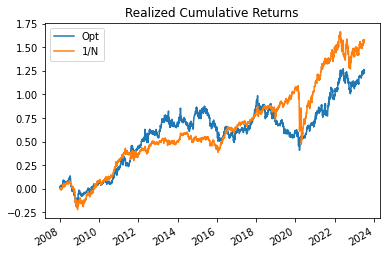

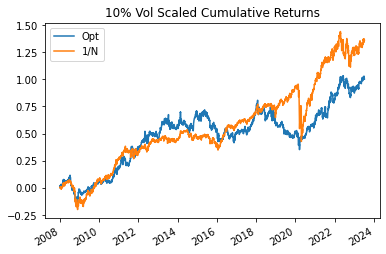

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.498                    0.604
Drift Adjusted Sharpe Ratio                    0.049                    0.162
CAGR                                           0.053                    0.063
Vol                                            0.118                    0.111
Sortino Ratio                                  0.678                    0.672
Martin (Ulcer) Ratio                           0.542                    1.004
Omega Ratio                                    0.987                    0.999
RR Ratio                                       1.090                    1.126
Win Rate                                       0.533                    0.541
Skew                                          -0.416                   -2.777
Kurtosis                                       6.827                   52.487
Max Drawdown                                  -0.292            

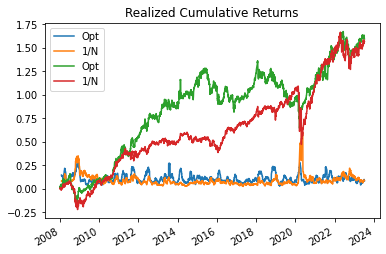

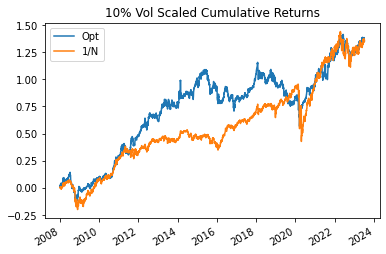

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.601                    0.604
Drift Adjusted Sharpe Ratio                    0.067                    0.162
CAGR                                           0.063                    0.063
Vol                                            0.113                    0.111
Sortino Ratio                                  0.830                    0.672
Martin (Ulcer) Ratio                           0.709                    1.004
Omega Ratio                                    1.000                    0.999
RR Ratio                                       1.111                    1.126
Win Rate                                       0.538                    0.541
Skew                                          -0.225                   -2.777
Kurtosis                                       6.067                   52.487
Max Drawdown                                  -0.304            

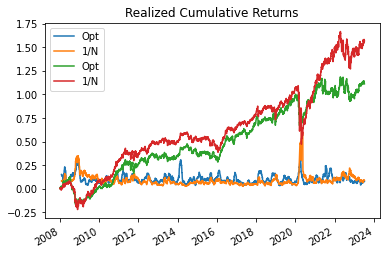

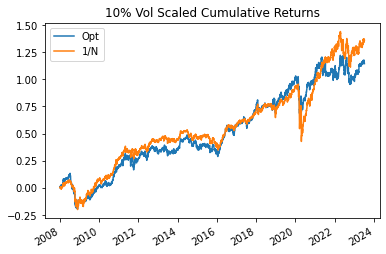

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.542                    0.604
Drift Adjusted Sharpe Ratio                    0.256                    0.162
CAGR                                           0.049                    0.063
Vol                                            0.098                    0.111
Sortino Ratio                                  0.686                    0.672
Martin (Ulcer) Ratio                           0.712                    1.004
Omega Ratio                                    0.973                    0.999
RR Ratio                                       1.102                    1.126
Win Rate                                       0.542                    0.541
Skew                                          -0.665                   -2.777
Kurtosis                                       8.818                   52.487
Max Drawdown                                  -0.285            

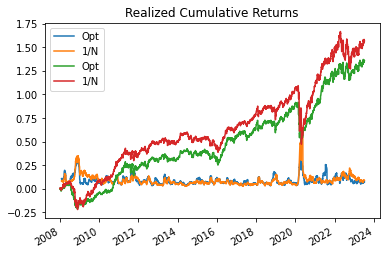

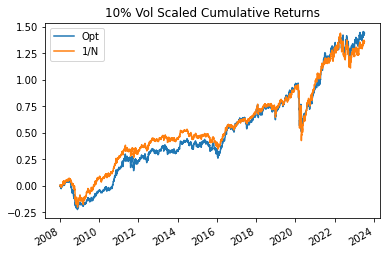

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.625                    0.604
Drift Adjusted Sharpe Ratio                    0.182                    0.162
CAGR                                           0.057                    0.063
Vol                                            0.096                    0.111
Sortino Ratio                                  0.757                    0.672
Martin (Ulcer) Ratio                           0.851                    1.004
Omega Ratio                                    0.985                    0.999
RR Ratio                                       1.120                    1.126
Win Rate                                       0.543                    0.541
Skew                                          -1.495                   -2.777
Kurtosis                                      21.473                   52.487
Max Drawdown                                  -0.261            

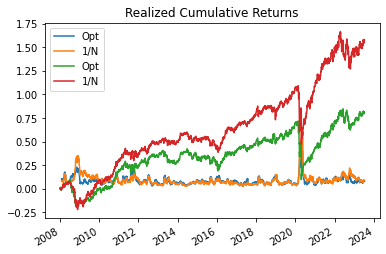

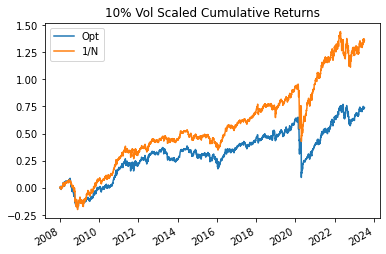

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.407                    0.604
Drift Adjusted Sharpe Ratio                    0.072                    0.162
CAGR                                           0.039                    0.063
Vol                                            0.109                    0.111
Sortino Ratio                                  0.424                    0.672
Martin (Ulcer) Ratio                           0.475                    1.004
Omega Ratio                                    0.958                    0.999
RR Ratio                                       1.084                    1.126
Win Rate                                       0.544                    0.541
Skew                                          -5.904                   -2.777
Kurtosis                                     149.598                   52.487
Max Drawdown                                  -0.362            

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Absolute, Temporal, & Asset Turnover: (55.891011691571734, 0.033724582359775775, 0.031508568459934334)
0.0968639084786696


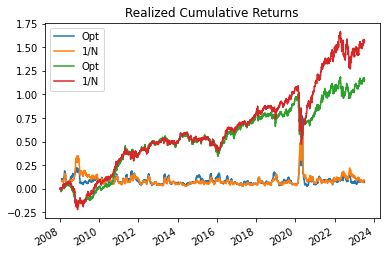

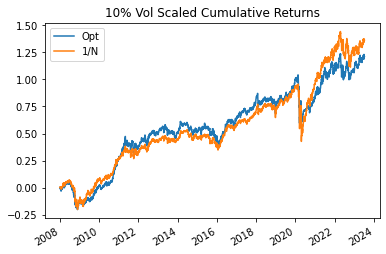

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.561                    0.604
Drift Adjusted Sharpe Ratio                    0.144                    0.162
CAGR                                           0.051                    0.063
Vol                                            0.097                    0.111
Sortino Ratio                                  0.688                    0.672
Martin (Ulcer) Ratio                           0.808                    1.004
Omega Ratio                                    0.975                    0.999
RR Ratio                                       1.108                    1.126
Win Rate                                       0.538                    0.541
Skew                                          -1.138                   -2.777
Kurtosis                                      16.743                   52.487
Max Drawdown                                  -0.233            

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Absolute, Temporal, & Asset Turnover: (54.51612529739646, 0.03301487927096087, 0.030678339719301805)
0.0931446901136497


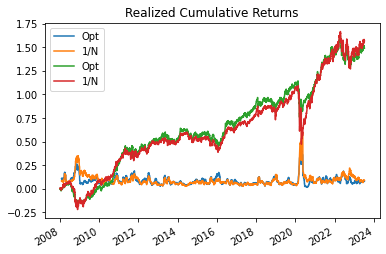

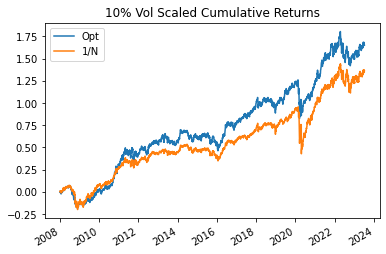

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.679                    0.604
Drift Adjusted Sharpe Ratio                    0.236                    0.162
CAGR                                           0.061                    0.063
Vol                                            0.093                    0.111
Sortino Ratio                                  0.889                    0.672
Martin (Ulcer) Ratio                           1.025                    1.004
Omega Ratio                                    0.992                    0.999
RR Ratio                                       1.126                    1.126
Win Rate                                       0.540                    0.541
Skew                                          -0.619                   -2.777
Kurtosis                                       7.799                   52.487
Max Drawdown                                  -0.225            

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Absolute, Temporal, & Asset Turnover: (53.54773497064286, 0.03338040468025205, 0.028007185672073207)
0.10488104842559229


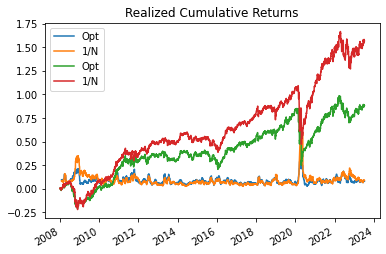

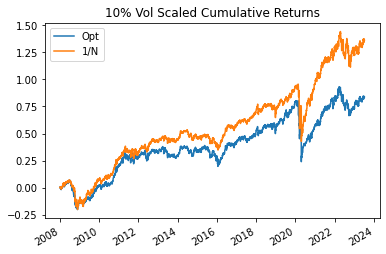

                             Opt Performance Summary  1/N Performance Summary
Sharpe Ratio                                   0.443                    0.604
Drift Adjusted Sharpe Ratio                    0.112                    0.162
CAGR                                           0.042                    0.063
Vol                                            0.105                    0.111
Sortino Ratio                                  0.475                    0.672
Martin (Ulcer) Ratio                           0.574                    1.004
Omega Ratio                                    0.961                    0.999
RR Ratio                                       1.090                    1.126
Win Rate                                       0.537                    0.541
Skew                                          -4.808                   -2.777
Kurtosis                                     111.715                   52.487
Max Drawdown                                  -0.325            

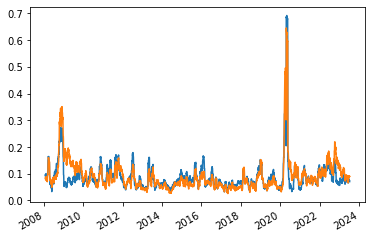

In [10]:
turnover_dict = {}

# Specify different turnover penalty terms
deltas = [.0001, .001, .01, .05, .1, .25, .5, 1]

for d in deltas:
    print(f"Turnover Constrained MVO -- Delta = {d}")
    opt_args = {'long_only':True, 'vol_target':.1, 'max_position_weight': 0.3, 'market_bias': 1, 'max_leverage' : 1, 'verbose': False, 'gamma' : 0.5, 'delta' : d}
    cov_args = {'apply_rolling_returns' : True, 'min_samples' : 21, 'lookback_vol' : 21, 'lookback_corr' : 60, 'shrinkage': 0, 'strict_min_samples' : False} # 'lookback_vol' : 21, 'lookback_corr' : 150, 'shrinkage': 0, 'strict_min_samples' : False}
    opt_object = opt.walk_forward_portfolio_optimization(returns=close_asset_returns.shift(2), opt_args=opt_args, cov_args=cov_args, rebal_freq=60, opt_method='risk_turnover_averse_mvo', cov_method='shrunken_ewma_cov', expected_return_method='mean')
    print(f"Absolute, Temporal, & Asset Turnover: {get_turnover(opt_object.rebal_w)}")
    print(plot_returns_from_opt(returns=opt_object.returns, w=opt_object.w))

    # Append turnover constrained optimization for given d (delta)
    turnover_dict[d] = get_turnover(opt_object.rebal_w)

In [13]:
# Create dicts to hold different categories of turnover statistics 
total_dict, temporal_dict, asset_dict = {}, {}, {}

# Separate each optimization's turnover statistics 
for key in turnover_dict.keys():
    total_dict[key], temporal_dict[key], asset_dict[key] = zip(turnover_dict[key])

# Convert to pd.Series for ease of data manipulation
total_dict = pd.Series(total_dict)
temporal_dict = pd.Series(temporal_dict)
asset_dict = pd.Series(temporal_dict)

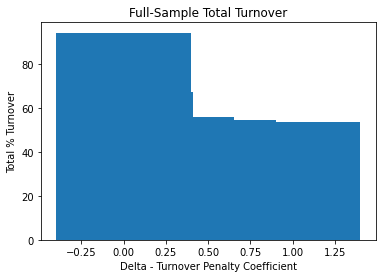

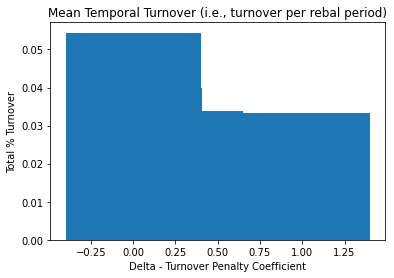

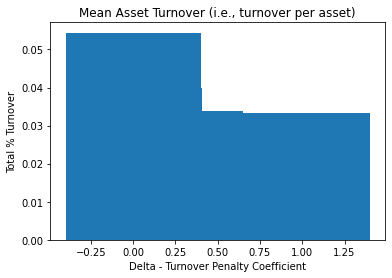

In [14]:
# Plot
plt.bar(total_dict.index, total_dict)
plt.title("Full-Sample Total Turnover")
plt.xlabel("Delta - Turnover Penalty Coefficient")
plt.ylabel("Total % Turnover")
plt.show()


plt.bar(temporal_dict.index, temporal_dict)
plt.title("Mean Temporal Turnover (i.e., turnover per rebal period)")
plt.xlabel("Delta - Turnover Penalty Coefficient")
plt.ylabel("Total % Turnover")
plt.show()


plt.bar(asset_dict.index, asset_dict)
plt.title("Mean Asset Turnover (i.e., turnover per asset)")
plt.xlabel("Delta - Turnover Penalty Coefficient")
plt.ylabel("Total % Turnover")
plt.show()